In [2]:
spark

In [27]:
spark.conf.set("spark.aoa.modelPath", "/tmp/aoa/spark")

dataset_url = "https://raw.githubusercontent.com/apache/spark/branch-2.4/data/mllib/sample_libsvm_data.txt"

In [41]:
# %%writefile ../training.py
import logging

from pyspark.ml.classification import LogisticRegression
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id 

logging.getLogger("py4j").setLevel(logging.ERROR)

# spark name and other properties are set by the framework launcher in spark-submit. don't override
spark = SparkSession.builder \
    .config(conf=SparkConf()) \
    .getOrCreate()


def read_dataset_from_url(spark, url):
    # for this demo we're downloading the dataset locally and then reading it. This is obviously not production setting
    # https://raw.githubusercontent.com/apache/spark/branch-2.4/data/mllib/sample_libsvm_data.txt
    urllib.request.urlretrieve(url, "/tmp/data.txt")
    return spark.read.format("libsvm").load("/tmp/data.txt")


train = read_dataset_from_url(spark, dataset_url)

lr = LogisticRegression(maxIter=10,
                        regParam=0.3,
                        elasticNetParam=0.8)

logging.info("Starting training...")

lr_model = lr.fit(train)

# Print the coefficients and intercept for logistic regression
logging.debug("Coefficients: {}".format(str(lr_model.coefficients)))
logging.debug("Intercept: {}".format(str(lr_model.intercept)))

logging.info("Finished training")

lr_model.write().overwrite().save(spark.conf.get("spark.aoa.modelPath"))
logging.info("Saved trained model")

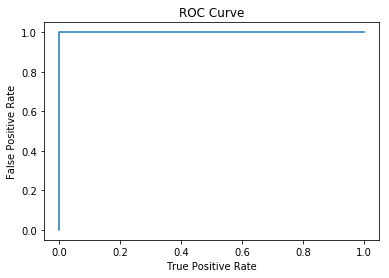

Training set areaUnderROC: 1.0


In [39]:
import matplotlib.pyplot as plt

summary = lr_model.summary
roc = summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(summary.areaUnderROC))

In [36]:
from pyspark.ml.classification import LogisticRegressionModel
lr_model = LogisticRegressionModel.load(spark.conf.get("spark.aoa.modelPath"))

test = read_dataset_from_url(spark, "https://raw.githubusercontent.com/apache/spark/branch-2.4/data/mllib/sample_libsvm_data.txt")

# add rowId for comparison later
test = test.select("*").withColumn("id", monotonically_increasing_id())

predictions = lr_model.transform(test)
predictions.show(10)

+-----+--------------------+---+--------------------+--------------------+----------+
|label|            features| id|       rawPrediction|         probability|prediction|
+-----+--------------------+---+--------------------+--------------------+----------+
|  0.0|(692,[127,128,129...|  0|[0.73765439548910...|[0.67648272431605...|       0.0|
|  1.0|(692,[158,159,160...|  1|[-1.2286964884747...|[0.22640965216205...|       1.0|
|  1.0|(692,[124,125,126...|  2|[-1.2596645795726...|[0.22103163838284...|       1.0|
|  1.0|(692,[152,153,154...|  3|[-1.0845333752697...|[0.25264907653471...|       1.0|
|  1.0|(692,[151,152,153...|  4|[-1.2371063245185...|[0.22494007343582...|       1.0|
|  0.0|(692,[129,130,131...|  5|[0.73839617859787...|[0.67664504514663...|       0.0|
|  1.0|(692,[158,159,160...|  6|[-1.2123284339889...|[0.22928932070495...|       1.0|
|  1.0|(692,[99,100,101,...|  7|[-0.2350856805053...|[0.44149776057216...|       1.0|
|  0.0|(692,[154,155,156...|  8|[0.10357406008713...|[

In [32]:
predictions.select("rawPrediction").show(10)

+--------------------+
|       rawPrediction|
+--------------------+
|[0.73765439548910...|
|[-1.2286964884747...|
|[-1.2596645795726...|
|[-1.0845333752697...|
|[-1.2371063245185...|
|[0.73839617859787...|
|[-1.2123284339889...|
|[-0.2350856805053...|
|[0.10357406008713...|
|[0.72217476589208...|
+--------------------+
only showing top 10 rows



In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0
